In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
from scipy.stats import pearsonr
from seaborn import heatmap

In [2]:
from sklearn.linear_model import LinearRegression
df = pd.read_csv('evraz_data.csv', sep=';', decimal=",")
y_cols = ['химшлак последний Al2O3', 'химшлак последний CaO', 
          'химшлак последний FeO', 'химшлак последний MgO',
          'химшлак последний MnO', 'химшлак последний R',
          'химшлак последний SiO2']
df

,Unnamed: 0,nplv,DT,МАРКА,ПРОФИЛЬ,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,0,г6837?3<87?,2070-06-21 00:14:00,Э76ХФ,Р65,29.0,45.366667,24.400000,41.033333,NaN,...,0.12,2.6,NaN,NaN,53.4,1.0,5.8,0.15,2.6,NaN
1,1,г683863<886,2070-06-21 01:07:00,Э76ХФ,Р65,26.0,44.066667,13.866667,44.066667,NaN,...,0.14,2.2,NaN,NaN,59.3,0.6,4.1,0.11,2.3,NaN
2,2,г683863<887,2070-06-21 02:00:00,Э76ХФ,Р65,24.0,43.350000,17.950000,43.350000,NaN,...,0.12,2.6,NaN,NaN,57.2,0.5,8.1,0.13,2.3,NaN
3,3,г683863<888,2070-06-21 02:58:00,Э76ХФ,Р65,17.0,46.183333,19.816667,46.183333,NaN,...,0.11,2.4,NaN,NaN,60.3,0.5,6.3,0.12,2.6,NaN
4,4,г683863<889,2070-06-21 03:50:00,Э76ХФ,Р65,20.0,48.500000,17.033333,48.500000,NaN,...,0.12,2.4,NaN,NaN,60.3,0.6,4.5,0.09,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036,7036,г68386398<;,2071-04-21 19:50:00,Э90ХАФ,Р65,41.0,42.333333,23.200000,42.166667,3.380628,...,0.10,2.6,22.2,7.0,60.6,0.4,6.2,0.06,2.7,22.8
7037,7037,г68386398<<,2071-04-21 20:45:00,Э90ХАФ,Р65,36.0,46.533333,16.183333,46.383333,NaN,...,0.10,2.2,24.5,4.9,53.0,0.5,11.1,0.25,2.4,22.3
7038,7038,г68386398<=,2071-04-21 21:34:00,Э90ХАФ,Р65,42.0,47.566667,23.016667,47.100000,2.263004,...,0.13,2.7,20.0,5.2,55.4,0.7,6.7,0.13,2.2,25.0
7039,7039,г68386398<>,2071-04-21 22:25:00,Э90ХАФ,Р65,45.0,46.033333,17.533333,45.683333,3.000000,...,0.18,2.1,24.5,4.9,55.1,0.4,8.9,0.16,2.1,26.0


In [3]:
# Убираем столбцы с NaN > 50%

exclude_columns = []
for column in df.columns:
    nas = df[column].isna().sum()
    print(column, nas)
    if nas > len(df)//2:
        exclude_columns.append(column)
    
df = df.drop(columns=exclude_columns)
print('Убраны столбцы:', exclude_columns)
print(df.shape)

Unnamed: 0 0
nplv 0
DT 0
МАРКА 0
ПРОФИЛЬ 0
t вып-обр 597
t обработка 601
t под током 601
t продувка 597
ПСН гр. 1792
чист расход C 606
чист расход Cr 1158
чист расход Mn 610
чист расход Si 610
чист расход V 863
температура первая 605
температура последняя 605
Ar (интенс.) 615
N2 (интенс.) 5652
эл. энергия (интенс.) 601
произв жидкая сталь 597
произв количество обработок 597
произв  количество плавок 597
произв количество плавок (цел) 597
расход газ Ar 615
расход газ  N2 5652
расход C пров. 6317
сыпуч известь РП 2271
сыпуч кварцит 7028
сыпуч кокс пыль УСТК 619
сыпуч  кокс. мелочь (сух.) 7034
сыпуч  кокс. мелочь КМ1 734
сыпуч  шпат плав. 1131
ферспл CaC2 797
ферспл FeMo 7008
ферспл FeSi-75 7036
ферспл FeV азот. 6658
ферспл  FeV-80 862
ферспл  Mn5Si65Al0.5 641
ферспл  Ni H1 пласт. 6959
ферспл SiMn18 643
ферспл  ферванит 6024
ферспл  фх850А 1158
эл. энергия 601
химсталь первый Al_1 597
химсталь первый C_1 597
химсталь первый Cr_1 597
химсталь первый Cu_1 597
химсталь первый Mn_1 597
химста

In [4]:
# Убираем столбцы с одним значением и со 100% уникальностью
exclude_columns = []
for column in df.columns:
    nunique = df[column].nunique()
    print(column, nunique)
    if nunique == 1 or nunique == len(df):
        exclude_columns.append(column)

df = df.drop(columns=exclude_columns)
print("Убраны столбцы:", exclude_columns)
print(df.shape)

Unnamed: 0 7041
nplv 7041
DT 7041
МАРКА 18
ПРОФИЛЬ 18
t вып-обр 82
t обработка 816
t под током 1155
t продувка 831
ПСН гр. 4296
чист расход C 6243
чист расход Cr 3115
чист расход Mn 6320
чист расход Si 6265
чист расход V 4645
температура первая 154
температура последняя 109
Ar (интенс.) 6423
эл. энергия (интенс.) 6362
произв жидкая сталь 175
произв количество обработок 3
произв  количество плавок 1
произв количество плавок (цел) 1
расход газ Ar 5548
сыпуч известь РП 441
сыпуч кокс пыль УСТК 306
сыпуч  кокс. мелочь КМ1 652
сыпуч  шпат плав. 177
ферспл CaC2 6
ферспл  FeV-80 650
ферспл  Mn5Si65Al0.5 368
ферспл SiMn18 497
ферспл  фх850А 370
эл. энергия 3132
химсталь первый Al_1 6
химсталь первый C_1 417
химсталь первый Cr_1 371
химсталь первый Cu_1 101
химсталь первый Mn_1 404
химсталь первый Mo_1 24
химсталь первый N_1 18
химсталь первый Ni_1 115
химсталь первый P_1 18
химсталь первый S_1 34
химсталь первый Si_1 384
химсталь первый Ti_1 7
химсталь первый V_1 28
химсталь последний Al 20
хи

In [5]:
df.groupby(by='произв количество обработок', as_index=False).agg({'произв количество обработок': pd.Series.count})

,произв количество обработок
0,6391.0
1,48.0
2,5.0


In [6]:
df = df.drop(columns='произв количество обработок')

In [7]:
df.groupby(by='МАРКА').agg({'МАРКА': pd.Series.count})

,МАРКА
МАРКА,
09Г2С,4
900А,54
G2HH,34
R260,35
R350HT,54
НХ,7
С255,2
С345,3
С355,1


In [8]:
df['МАРКА'][~df['МАРКА'].isin(['Э76ХФ', 'Э90ХАФ'])] = 'другое'  
df.groupby(by='МАРКА').agg({'МАРКА': pd.Series.count})

<ipython-input-8-eb37f575351c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['МАРКА'][~df['МАРКА'].isin(['Э76ХФ', 'Э90ХАФ'])] = 'другое'


,МАРКА
МАРКА,
Э76ХФ,4953
Э90ХАФ,1384
другое,704


In [9]:
df.groupby(by='ПРОФИЛЬ').agg({'ПРОФИЛЬ': pd.Series.count})
df = df.drop(columns='ПРОФИЛЬ')

In [10]:
# Отделим кат признаки (в конце ноутбука в ключим обратно)
cat_X = df['МАРКА']
df = df.drop(columns=['МАРКА'])

In [11]:
# Удаление строк с NaN > 33%
row_indexes_to_exclude = []

number_of_columns_in_dataframe = len(df.columns)
for index, row in df.iterrows():
    NaN_count = row.isna().sum()
    if NaN_count > number_of_columns_in_dataframe*(1/3):
        row_indexes_to_exclude.append(index)

cat_X = cat_X.drop(df.index[row_indexes_to_exclude])
df = df.drop(df.index[row_indexes_to_exclude])
print(df.shape)

(6443, 67)


In [12]:
for column in y_cols:
    column = column.replace('последний', 'первый') + '_1'
    nas = df[column].isna().sum()
    print(column, nas)
# Много пропусков в колонках 'химшлак последний Al2O3' и 'химшлак последний SiO2'
# Сделаем из них доп кат переменные
al2o3_is_na_col = df['химшлак первый Al2O3_1'].isna().astype(int)
al2o3_is_na_col.name = 'химшлак первый Al2O3_1 == NaN'
sio2_is_na_col = df['химшлак первый SiO2_1'].isna().astype(int)
sio2_is_na_col.name = 'химшлак первый SiO2_1 == NaN'

химшлак первый Al2O3_1 1701
химшлак первый CaO_1 0
химшлак первый FeO_1 0
химшлак первый MgO_1 1
химшлак первый MnO_1 0
химшлак первый R_1 0
химшлак первый SiO2_1 1701


In [13]:
# Заполняем NaN'ы средними

for column in df.columns:
    print(column, df[column].mean())
    df[column].fillna(df[column].mean(), inplace=True)
print(df.shape)


t вып-обр 26.48967872109266
t обработка 46.198628150815345
t под током 21.01052277470497
t продувка 46.067556521356515
ПСН гр. 3.0044144825681083
чист расход C 0.403087871934732
чист расход Cr 0.11769215213326534
чист расход Mn 0.13906832475509254
чист расход Si 0.13056103560877003
чист расход V 0.05136576458400777
температура первая 1567.7717526413921
температура последняя 1587.9738968303293
Ar (интенс.) 11.59433169218677
эл. энергия (интенс.) 12989.038791407158
произв жидкая сталь 114.40460965446219
расход газ Ar 15.452724046723738
сыпуч известь РП 0.1321788260167715
сыпуч кокс пыль УСТК 0.06670647810650888
сыпуч  кокс. мелочь КМ1 0.42016204219121617
сыпуч  шпат плав. 0.05472961086294416
ферспл CaC2 0.020086483119795
ферспл  FeV-80 0.06136827366887846
ферспл  Mn5Si65Al0.5 0.14343640629687499
ферспл SiMn18 0.2155398562988434
ферспл  фх850А 0.2080389257861635
эл. энергия 4557.236180124223
химсталь первый Al_1 0.0017822442961353414
химсталь первый C_1 0.4661747633090176
химсталь первый 

In [14]:
# Удаленние выбросов
isfor = IsolationForest()
isfor.fit(df)
isfor_pred = isfor.predict(df)

df = df[isfor_pred==1]
cat_X = cat_X[isfor_pred==1]
al2o3_is_na_col = al2o3_is_na_col[isfor_pred==1]
sio2_is_na_col = sio2_is_na_col[isfor_pred==1]

print(df.shape)

(6300, 67)


In [15]:
# Отделяем y

X = df.drop(columns=y_cols)
y = df.filter(y_cols)

print(X.shape)
print(y.shape)

(6300, 60)
(6300, 7)


In [16]:
# # Удаление выбросов по y 
# isfor = IsolationForest()
# isfor.fit(y)
# isfor_pred = isfor.predict(y)
# print('Осталось объектов:', sum(isfor_pred[isfor_pred==1])/y.shape[0] * 100)
# y = y[isfor_pred==1]
# X = X[isfor_pred==1]
# print(X.shape, y.shape)

# pca = PCA(n_components=3)
# pca_y = pca.fit_transform(y)
# plt.scatter(pca_y[:,0], pca_y[:,1], pca_y[:,2])

In [17]:
y.describe()

,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
count,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000,6300.000000
mean,4.598178,56.419714,0.584619,9.016391,0.121592,2.363638,23.961298
std,0.814553,3.768577,0.211834,3.146553,0.059462,0.223933,1.874762
min,2.400000,35.900000,0.100000,0.300000,0.040000,1.700000,16.400000
25%,4.100000,54.300000,0.400000,6.700000,0.080000,2.200000,22.700000
50%,4.597912,56.800000,0.600000,8.900000,0.110000,2.300000,23.971700
75%,4.900000,58.800000,0.700000,11.200000,0.140000,2.500000,25.500000
max,14.200000,67.500000,2.300000,32.400000,1.450000,3.100000,28.700000


(0.0, 1.0, 0.0, 1.0)

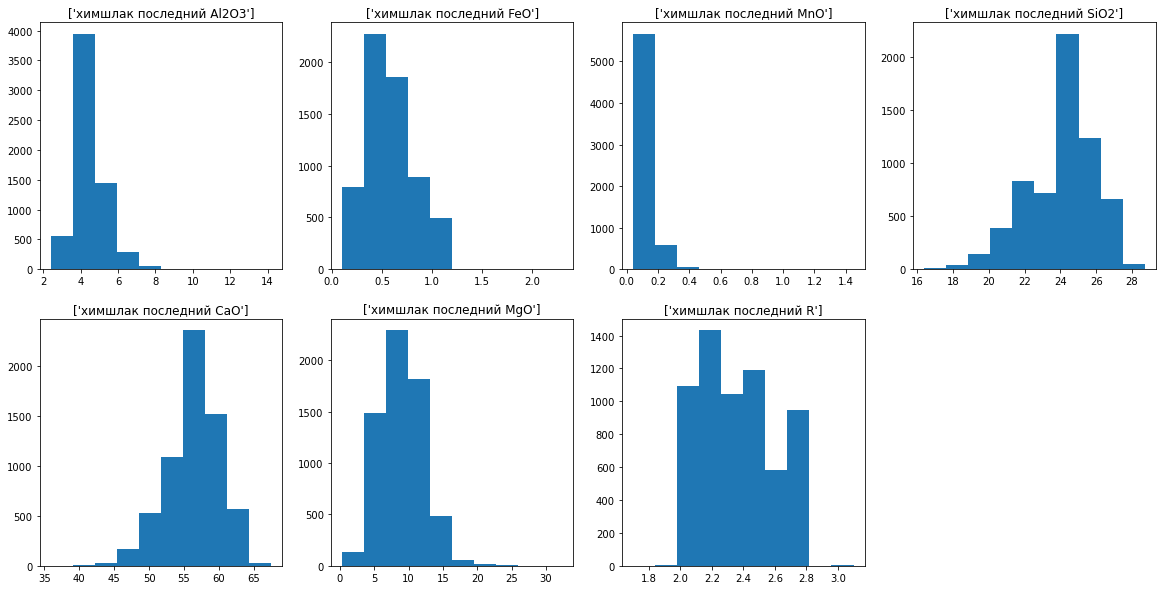

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(len(y_cols)):
    axs[i%2, i//2].hist(y[y_cols[i]])
    axs[i%2, i//2].set_title([y_cols[i]])
axs[-1,-1].axis('off')

## Поиск линейно зависимых столбцов

In [19]:
# "Линейность" будем оценивать коээфициентом 
# Из полученных оценок можно построить граф и проверить, нет ли цепочек линейной зависимости
# в случае их присутсвия придется более аккуратно удалять столбцы 
cols_checked = [] # Для уменьшение повторов в анализе, линейная зависимость коммутативна
linearity_graph_edges = []
x_cols = list(X.columns)
for x_col_l in tqdm(range(len(x_cols))):
    x_col_l = x_cols[x_col_l]
    cols_checked.append(x_col_l)
    for x_col_r in x_cols:
        if x_col_r in cols_checked:
            continue
        corr, p = pearsonr(X[x_col_l], X[x_col_r])
        # if p < 0.95:
        #     continue
        linearity = abs(corr)
        linearity_graph_edges.append((x_cols.index(x_col_l), 
                            x_cols.index(x_col_r),
                            linearity))
linearity_graph_edges.sort(key = lambda v: v[2])
print(len(linearity_graph_edges))

100%|██████████| 60/60 [00:02<00:00, 23.75it/s]


1770


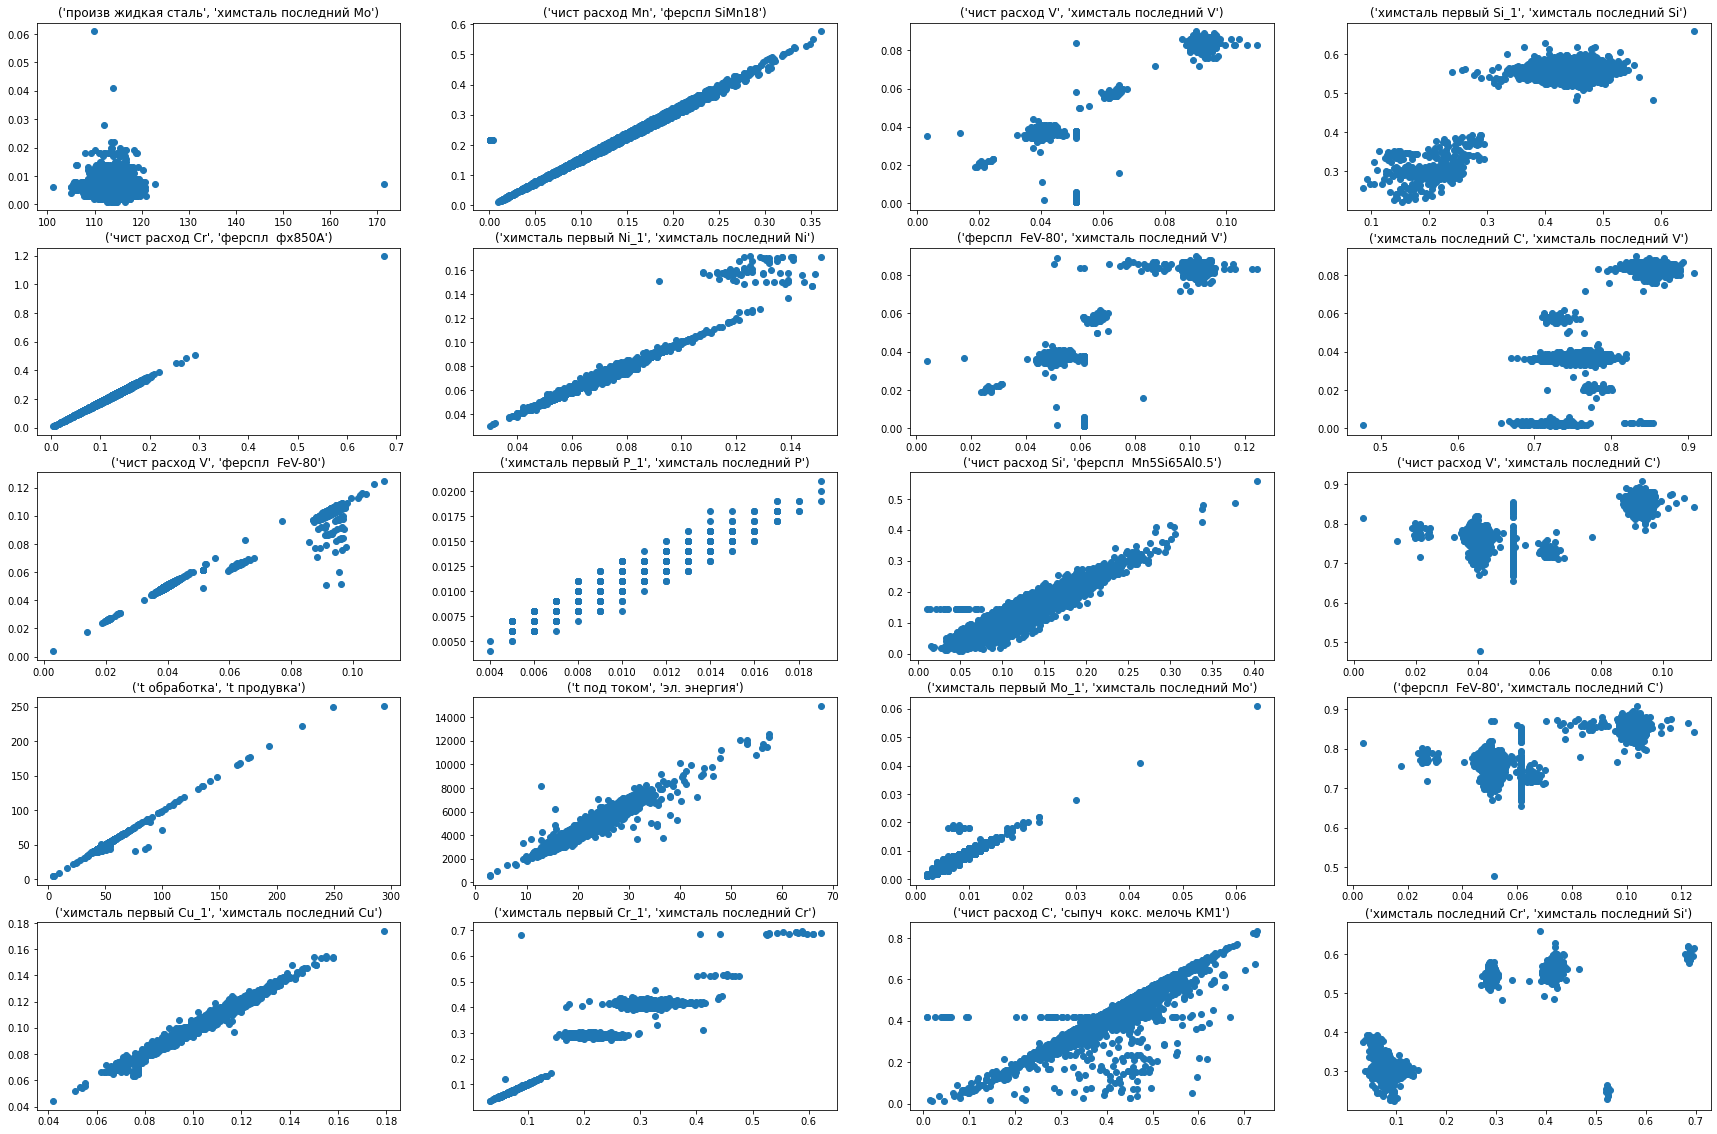

In [20]:
# Можно вывести все остальные графики попарных отношений, но остановимся на топ-20
# У первых шести видна четкая линейность

fig, axs = plt.subplots(5, 4, figsize=(30, 20))
for i in range(20):
    x1, x2, mse_val = linearity_graph_edges[-i]
    axs[i%5, i//5].scatter(X[x_cols[x1]], X[x_cols[x2]])
    axs[i%5, i//5].set_title(f'{x_cols[x1], x_cols[x2]}')

In [21]:
# # Уберем столбцы из топ-5 отношений
# # По графу можно увидеть, что в графе нет цепочек "линейности", что упрощает задачу удаления столбцов        
# G = nx.Graph()
# G.add_weighted_edges_from(linearity_graph_edges[-20:])
# nx.draw(G, with_labels=True)

In [22]:
# Удалим один из столбцов из линейных пар
print(X.shape)
# dropped_columns = [x_cols[edge[0]] for edge in linearity_graph_edges[-7:]]
# Глядя на графики попарных зависимостей, можно выбрать колонки для удаления 
dropped_columns = ['чист расход Mn',
                      'чист расход Cr',
                      'чист расход V',
                      'чист расход Si',
                      'чист расход C',
                      't под током',
                      't обработка',
                      'химсталь первый Cu_1',
                      'химсталь первый Ni_1'
                      ]
X = X.drop(columns=dropped_columns)
print('Удалены признаки:', dropped_columns)
print(X.shape)

(6300, 60)
Удалены признаки: ['чист расход Mn', 'чист расход Cr', 'чист расход V', 'чист расход Si', 'чист расход C', 't под током', 't обработка', 'химсталь первый Cu_1', 'химсталь первый Ni_1']
(6300, 51)


In [23]:
# Категориальные признаки
cat_X = pd.get_dummies(cat_X) # Кодирование категориальных данных
# all_X = pd.concat([X, cat_X, al2o3_is_na_col, sio2_is_na_col], axis=1)
all_X = pd.concat([X, al2o3_is_na_col, sio2_is_na_col], axis=1)

In [24]:
print(X.shape)
print(al2o3_is_na_col.shape)
print(sio2_is_na_col.shape)
print(cat_X.shape)
print(all_X.shape)
print(y.shape)

(6300, 51)
(6300,)
(6300,)
(6300, 3)
(6300, 53)
(6300, 7)


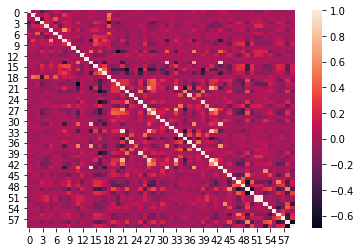

In [25]:
cov = np.corrcoef(np.hstack([all_X, y]).transpose())
heatmap(cov)

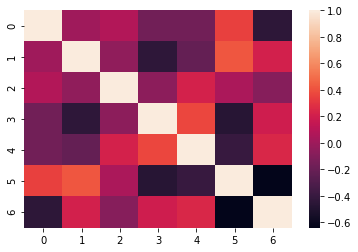

In [26]:
cov = np.corrcoef(y.transpose())
heatmap(cov)

In [27]:
all_X.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)
